In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
 
import tushare as ts
pro = ts.pro_api('9293b9b01414a95f89aa75f884c907fdc2cd24f41c8ea3de863eaa26')


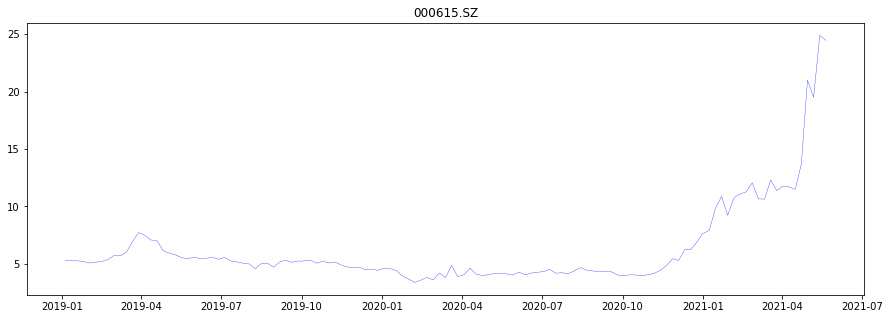

In [2]:
#复权个股日线

#tc = '399300.SZ'
tc = '000615.SZ'

data = ts.pro_bar(api=pro, ts_code=tc, adj='qfq', start_date='20190101', end_date='20210525',freq='w')  ##个股日线freq='d' 周线freq='w'
#data = pro.index_daily(ts_code=tc, adj='qfq', start_date='20200101', end_date='20210525')     ##指数日线
#data = pro.index_weekly(ts_code=tc, adj='qfq', start_date='20190101', end_date='20210525')    ##指数周线

data = data[::-1].reset_index(drop=True)
data['trade_date'] = pd.to_datetime(data['trade_date'],format='%Y%m%d')
data.set_index('trade_date', inplace=True)
data = data.tail(200)
#print(data)

plt.figure(figsize=(15, 5))
#plt.figure(figsize=(10,6), dpi=256)
plt.title(str(tc))

plt.plot(data['close'], color="blue", linewidth=0.3, linestyle="-")
#plt.plot(data['pre_close'], color = "red",  linewidth=0.3, linestyle="-")
 

In [3]:
def ssa(series, windowLen , pcn  ):
    seriesLen = len(series)
    K = seriesLen - windowLen + 1
    X = np.zeros((windowLen, K))
    for i in range(K):
        X[:, i] = series[i:i + windowLen]
    
    U, sigma, VT = np.linalg.svd(X, full_matrices=False)

    for i in range(VT.shape[0]):
        VT[i, :] *= sigma[i]
    A = VT

    rec = np.zeros((windowLen, seriesLen))
    for i in range(windowLen):
        for j in range(windowLen-1):
            for m in range(j+1):
                rec[i, j] += A[i, j-m] * U[m, i]
            rec[i, j] /= (j+1)
        for j in range(windowLen-1, seriesLen - windowLen + 1):
            for m in range(windowLen):
                rec[i, j] += A[i, j-m] * U[m, i]
            rec[i, j] /= windowLen
        for j in range(seriesLen - windowLen + 1, seriesLen):
            for m in range(j-seriesLen+windowLen, windowLen):
                rec[i, j] += A[i, j - m] * U[m, i]
            rec[i, j] /= (seriesLen - j)
    
    result = np.sum(rec[:pcn], axis=0)
    return result[-1]
    #return result

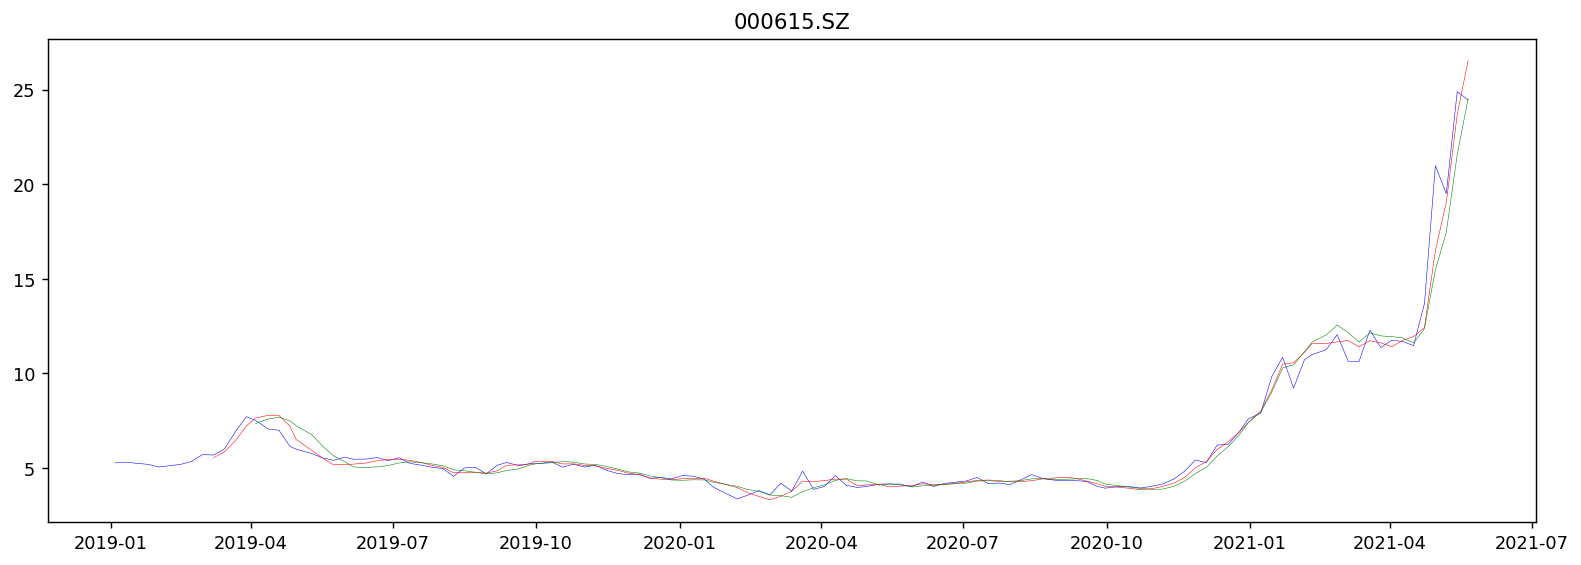

In [4]:
pcn = 1
fwl = 5
swl = 7

#print(series)
#---------------------------------双SSA-------------------------------------------------
data['f_ssa']= data['close'].rolling(2*fwl - 1).apply(ssa,args = (fwl,pcn),raw = True) 
data['s_ssa'] = data['close'].rolling(2*swl - 1).apply(ssa,args = (swl,pcn),raw = True) 
#---------------------------------------------------------------------------------------
plt.figure(figsize=(15, 5), dpi=128)
#plt.figure(figsize=(10,6), dpi=256)
plt.title(str(tc))

plt.plot(data['close'], color="blue", linewidth=0.3, linestyle="-")
plt.plot(data['f_ssa'], color = "red",  linewidth=0.3, linestyle="-")
plt.plot(data['s_ssa'], color = "green",  linewidth=0.3, linestyle="-")